<a href="https://colab.research.google.com/github/ITMK/DataLitMT/blob/main/colab_notebook_advanced_level.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

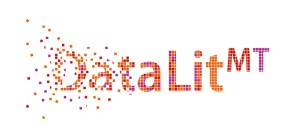

# Data Evaluation – Advanced Level
**MT Quality Score Calculator for Metrics Based on String Matching and for Embedding-based Metrics**

# Introduction

This is a Colab notebook for calculating automatic metrics for machine translation (MT) quality evaluation, which covers the *Data Evaluation* dimension of the [DataLit<sup>MT</sup> Competence Matrix](https://itmk.github.io/The-DataLitMT-Project/matrix/) and here particularly the subdimensions of *Data Analysis*, *Data Verbalisation* (to some extent) and *Data Interpretation*. Given that MT systems are increasingly used as productivity-enhancing tools in the professional translation process, both manual and automatic evaluation of MT output become more and more important. Automatic MT quality evaluation is part of *Technical MT Literacy*, as illustrated in the [Professional Machine Translation Literacy Framework](https://itmk.github.io/The-DataLitMT-Project/framework/#professional-mt-literacy). In this notebook, we will introduce two traditional MT quality metrics based on string matching and two modern embedding-based metrics, and we will illustrate the differences between these metrics. After working through this notebook, you should have a good grasp of how automatic MT quality evaluation works and how the various scores differ from each other.

The code used for the score calculations in this notebook is adopted from the Natural Language Toolkit ([NLTK](https://www.nltk.org/)) and the respective GitHub repositories of each metric (references will be given throughout the notebook). The basic concepts employed in the various MT quality scores will be explained by introducing the individual metrics and illustrating how they work and how their scores are to be interpreted.

All metrics presented in this notebook (with the exception of the COMET model for MT quality estimation covered in section 4.2) are based on a comparison between a machine-translated sentence (which is often called *hypothesis* in MT research) and a corresponding human reference translation (*reference*), which is the 'gold standard' that any MT hypothesis should strive to achieve (in the logic of automatic MT quality metrics). The reference can already exist (e. g., an official translation of specific texts) or you can create it yourself by either translating the source text yourself or by post-editing the output of an MT system.

The fundamental distinction we make in this notebook is between traditional MT quality scores which rely on exact string matching between string A (MT output/hypothesis) and string B (reference translation/gold standard) to calculate the similarity or dissimilarity between the two strings, and embedding-based metrics, which use the concept of word *embeddings* to calculate the (dis)similarity between hypothesis and reference based on the relative proximity of their word embeddings in high-dimensional vector space. If you’re confused right now, don’t worry, we will explain all of this in more detail in the course of this notebook.

## 0 Housekeeping

You can run all cells in this notebook without having to change any of the code. However, in the examples discussed below, feel free to enter your own MT and reference sentences, if you'd like to calculate individual scores.

First, we need to ensure that we installed/upgraded the Python installer *pip*, which we will use to install external libraries in our notebook. To do so, run the cell below.

In [ ]:
# Upgrade to the current version of pip
!pip install --upgrade pip

That’s it, you’re ready to go!

# String-based Metrics

In this section, we cover traditional MT quality evaluation metrics which are based on the comparison of two strings, i.e., the MT output/hypothesis and the human reference translation. A full understanding of these string matching-based metrics relies on understanding the three basic concepts of *precision*, *recall* and *n-gram*. In order to avoid overcrowding the current notebook, we created [a companion notebook for automatic MT quality evaluation metrics based on string matching](https://colab.research.google.com/drive/1G0uwf5kPG5d5kmd-LbvkkssKoza9N622?usp=sharing), which covers these three concepts in detail. You should get an adequate understanding of traditional MT quality metrics without working through this companion notebook. However, if you want to get down to the nuts and bolts of these metrics, the companion notebook is the place to start.

## 1 BLEU (a similarity measure)

BLEU is an acronym for **B**i**L**ingual **E**valuation **U**nderstudy. It was originally proposed in [Papineni et al. (2002): BLEU: A Method for Automatic Evaluation of Machine Translation](https://www.aclweb.org/anthology/P02-1040.pdf). BLEU is still a commonly used automatic MT quality score because it is widely known in MT research and practice and it often achieves reasonably good correlations with human quality judgements. (A high correlation with human quality judgements is considered the ultimate ‘seal of approval’ for any automatic MT quality evaluation metric.)

BLEU is a similarity measure, which derives its name from the fact that it measures the degree of similarity between two strings (i.e., the degree of similarity between the machine-translated sentence and the human-translated reference sentence). The closer the machine translation is to the reference translation, the better is the quality of the MT output (remember that we consider the reference to be our gold standard). Therefore, the *higher* the BLEU score calculated for a given MT output/reference pair, the *higher* the quality of the MT output is assumed to be, and vice versa. BLEU is calculated using the following formula:

$$BLEU = min(1, \frac{hypothesis\;length}{reference\;length})(\displaystyle\prod_{i=1}^{n} precision_i)^{\frac{1}{n}}$$

Let's break this down:

$(\displaystyle\prod_{i=1}^{n} precision_i)^{\frac{1}{n}}$: This part of the formula looks somewhat complicated, but it is actually quite simple. It says:  

**1)** $precision_i$: Find the individual precision values (n-grams that appear both in the hypothesis and in the reference) for 1-grams, 2-grams, 3-grams and 4-grams (the upper limit of 4 is not given in the formula, but the common BLEU score implementations used in MT research compute up to the n-gram value of 4). This will give you values such as $\frac{4}{7}$ (4 out of 7 possible 1-gram matches), $\frac{3}{6}$ (3 out of 6 possible 2-gram matches), $\frac{2}{5}$ (2 out of 5 possible 3-gram matches) and $\frac{1}{4}$ (1 out of 4 possible 4-gram matches). (These are fictional values used merely for illustration purposes. We’ll discuss real BLEU scores below.)

**2)** $\displaystyle\prod_{i=1}^{n}$ and $\frac{1}{n}$: Calculate the geometric mean of the n-gram precision values. To calculate the geometric mean, we multiply our $n$ precision values and then take the $n$-th root of the product of these values. In our example, we have 1- to 4-grams (four precision values, therefore $n = 4$), so we multiply $\frac{4}{7}\times\frac{3}{6}\times\frac{2}{5}\times\frac{1}{4}$ and then take the fourth root of this product. Calculating the $n$-th root of a number is equivalent to raising this number to the exponent $\frac{1}{n}$ ($\frac{1}{4}$ in our example). So, our final calculation in this case would be $(\frac{4}{7}\times\frac{3}{6}\times\frac{2}{5}\times\frac{1}{4})^{\frac{1}{4}}$.    


$min(1, \frac{hypothesis\;length}{reference\;length})$: This part of the formula is called *brevity penalty* and it penalizes MT hypotheses that are shorter than their references (if the hypothesis is shorter than the reference, we fear that the MT system forgot to translate certain words). You may have noticed that BLEU works with precision but not recall values. The brevity penalty is BLEU's 'substitute' for recall, if you will. Suppose our hypothesis contains 6 words and the reference contains 7. If we plug these values into the formula, we get $min(1, \frac{6}{7})$. This simply means: take the smaller of the two values (here, $\frac{6}{7}$) and multiply it with the previous part of the BLEU formula. Since we multiply with a value smaller than 1, the overall BLEU score will decrease as a result of this multiplication. In other words, a brevity penalty was applied which reduces the overall BLEU score. If the hypothesis contained 7 words and the reference 6 words, we'd get $min(1, \frac{7}{6})$. In this case, the smaller of the two values is 1, and if we multiply the previous part of the BLEU formula with 1, nothing happens. In other words, in this case (where the hypothesis is longer than the reference) no brevity penalty is applied.

BLEU scores published in official machine translation competitions such as the [Conference on Machine Translation (WMT)](http://www.statmt.org/wmt20/) are calculated using the [SacreBLEU](https://github.com/mjpost/sacrebleu) package. SacreBLEU is a standardised method for BLEU score calculation allowing the comparison of BLEU scores provided by different MT developers for different MT systems. sacreBLEU was originally proposed in [Post (2018): A Call for Clarity in Reporting BLEU Scores](https://arxiv.org/abs/1804.08771). To follow good industry practice, we also use sacreBLEU in this notebook.

### 1.0 Installing sacreBLEU

Run the cell below to install sacreBLEU.

In [ ]:
# Import sacreBLEU functions
!pip install sacrebleu
import sacrebleu

###1.1 Short Example

In the example below, we define a human reference sentence and a machine-translated hypothesis. For these two sentences (which we’ll encounter at various points in this notebook), we can calculate a BLEU score. Run the following cell to do so.

In [ ]:
# Define reference and hypothesis
hypothesis_sacreBLEU = ['I drove the automobile to the gasoline station'] 
reference_sacreBLEU = ['I drove the car to the gas station']                                                                                                                                                 

# Calculate and print sacreBLEU score
sacrebleu.corpus_bleu(hypothesis_sacreBLEU, [reference_sacreBLEU])

As you can see, we get a BLEU score of 27.05 (indicated by *BLEU = 27.05*). The scale here ranges from 0 to 100, so 27.05 is a below-average value (note that the two sentences express basically the same meaning, albeit using slightly different words). In real-life MT quality evaluation scenarios, BLEU scores are rarely as high as 100 (which would mean that the MT output is identical to the reference translation) and usually start being competitive from 20 upward.
Above, you can see four additional values following the BLEU score. Those are the values of the individual n-gram precisions from the BLEU formula discussed above. So, for 1-gram precision, it scores 75.0 (i.e., 6 of 8 words in the hypothesis are also in the reference, which is equal to 75%), for 2-gram precision, it scores 42.9 (example: 'I drove' and 'drove the', but not 'the automobile'), for 3-gram precision, it scores 16.7 (only 'I drove the') and for 4-gram precision it scores 10.0 (no 4-gram overlaps between hypothesis and reference). You may wonder why we get a 4-gram precision value of 10.0 even if there are no 4-gram overlaps in our example. The reason is that, in such cases, a so-called *smoothing function* is applied, which assigns a small value (here, 10.0) to the n-gram precision value that would otherwise be 0. This is done to avoid that, if one of the n-gram precisions is zero, the overall BLEU score drops to 0 (remember that we multiply the individual n-gram precisions, and if one of the factors is 0, the whole product will be 0). We won't discuss smoothing in any further detail here. For an overview of different smoothing methods used in BLEU score calculation, see [Chen/Cherry (2014): A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU](https://www.aclweb.org/anthology/W14-3346/). In the code cell above, further values are indicates. *BP* stands for *brevity penalty*, and ratio is calculated by dividing the length of the hypothesis (*hyp_len*) by the length of the reference (*ref_len*), as described in the BLEU formula above. Since hypothesis and reference are of equal length, the ratio and hence the brevity penalty will be 1. In other words, nothing happens, because no brevity penalty is applied (again, see our discussion of the BLEU formula above).

###1.2 Your Own Example

If you would like to test BLEU score calculation with an example of your own, run the first code cell below and then type in your own example sentences in the field below the cell (both times, confirm with Enter). Then, run the second cell below in order to calculate the BLEU score for your sentences.

In [ ]:
# Enter machine-translated sentence (hypothesis) and the human reference translation (reference)
own_hypothesis = input("\nEnter the machine-translated sentence here: ")
own_reference = input("\nEnter the human-translated sentence here: ")

In [ ]:
# Calculate and print your own sacreBLEU score
sacrebleu.corpus_bleu([own_hypothesis], [[own_reference]])

If you use hypothesis and reference sentences of different length, pay particular attention to the values for *BP* and *ratio*, which will be more interesting than in our example above. You can always come back here to calculate further BLEU scores.

## 2 TER

In addition to string-based *similarity* measures, there are also string-based *distance* measures. These derive their name from the fact that they measure the degree of *dissimilarity* or distance between two strings. Accordingly, the *higher* the score calculated by these metrics, the *lower* the quality of the MT output is assumed to be, and vice versa (opposite to the scores of similarity measures such as BLEU).

**TER** is an acronym for **T**ranslation **E**dit **R**ate, originally proposed in [Snover et al. (2006): A Study of Translation Edit Rate with Targeted Human Annotation](http://www.cs.umd.edu/~snover/pub/amta06/ter_amta.pdf). TER is calculated using the following formula:  

$$TER = \frac{substitutions + insertions + deletions + shifts}{reference\;length}$$  

So, TER simply sums the number of editing operations required to transform a hypothesis into a reference and divides the number of editing operations through the length of the reference in order to normalize the score (normalizing the score makes it comparable to other TER scores which may have been calculated for reference sentences with different lengths). The editing operations allowed are substituting one element for another (substitution), inserting or deleting an element (insertion/deletion) and moving an element to another position in the string (shift). TER is usually calculated on the basis of words, however, a character-based TER calculation is also possible (called [characTER](https://aclanthology.org/W16-2342/)). In this notebook, we use the standard word-based TER.

### 2.0 Installing TER

For calculating TER, we need to install the [pyter](https://pypi.org/project/pyter3/) and import some NLTK functions. This is done by running the code below.

In [ ]:
# Install the current version of the pyter package
!pip install --upgrade pyter3

# Import ter() and word_tokenize() functions
from pyter import ter
from nltk import word_tokenize

import nltk
nltk.download('punkt')

### 2.1 Short Example

In the example below, we define the same reference and hypothesis sentences we used for our BLEU score calculation. For these two sentences, we can then calculate a TER score. Run the following cell to calculate the score.

In [ ]:
# Define reference and hypothesis
hypothesis_ter = 'I drove the automobile to the gasoline station'
reference_ter = 'I drove the car to the gas station'

# Calculate and print Translation Edit Rate
TER = ter(word_tokenize(hypothesis_ter), word_tokenize(reference_ter))
print(f"TER: {TER}")

As you can see, we obtain a TER score of 0.25 (with the scale of possible scores ranging from 0 to 1). We arrive at this value as follows: If we look at our hypothesis/reference pair, we see that we can transform the hypothesis into the reference by (1) substituting *automobile* by *car* and (2) by substituting *gasoline* by *gas*. We sum up the two editing operations and divide them by the length of the reference sentence (8 words), and 2/8 = 0.25. In other words, our editing effort amounted to 25 %, which is rather low, indicating a good quality of the MT output (remember, the lower the TER score, the higher and MT quality and vice versa). Note that our BLEU score for our hypothesis/reference pair indicated a rather poor MT quality (27.05 of 100, with BLEU being a similarity measure -> the higher the score the better the MT quality and vice versa), while our TER score indicates a good MT quality. This is a good lesson to learn: Automatic MT quality scores should never be taken at face value. Always ask yourself how the metric for which the score was calculated actually works and *what the score means in relation to the operating principle of this metric!*

TER or similar distance measures are often used in the translation industry for calculating the post-editing effort involved in MT-assisted translation projects (which can then be used for price calculation). For more information on this topic, see, e.g. the article by [Kirchner (2020)](https://aclanthology.org/2020.eamt-1.38/).

### 2.2 Your Own Example

If you would like to test TER score calculation with an example of your own, run the first code cell below and then type in your own example sentences in the field below the cell (both times, confirm with Enter). Then, run the second cell below in order to calculate the TER score for your sentences (the same as under 1.2).

In [ ]:
# Enter machine-translated sentence (hypothesis) and the human reference translation (reference)
own_ter_hypothesis = input("\nEnter the machine-translated sentence here: ")
own_ter_reference = input("\nEnter the human-translated sentence here: ")

In [ ]:
# Calculate and print your own Translation Edit Rate
TER = ter(word_tokenize(own_ter_hypothesis), word_tokenize(own_ter_reference))
print(f"TER: {TER}")

Again, feel free to come back here any time to calculate further TER scores.

# Embedding-based Metrics BERTScore and COMET

Now that we are familiar with traditional MT quality metrics based on string matching, we can move on to modern quality metrics which are based on embeddings. These embedding-based metrics are a bit more complex than the traditional string matching-based metrics. In particular, we need to understand the concept of *word embeddings*, which are high-dimensional vector representations of words. Again, in order to avoid overcrowding the current notebook, we have created [a companion notebook for embedding-based MT quality metrics](https://colab.research.google.com/drive/1qM9srwtTfaapTnKcQGMYct1iFGyL1XjB?usp=sharing). We highly recommend that you work through this companion notebook before moving on to the metrics discussed in the following sections. Once you have a good grasp at what word embeddings are and how they work, you are well-equipped to understand the basic operating principle not only of the embedding-based metrics discussed here but also of high-performing natural language processing technologies such as neural machine translation or large language models such as ChatGPT (all of which use word embeddings as their fundamental building blocks). For the following discussion, we assume such a basic understanding of word embeddings.
Within modern embedding-based metrics, a distinction can be made between metrics which rely solely on semantic *similarity* between hypothesis and reference based on proximity in vector space, and metrics which rely both on this semantic similarity in vector space and on previous human quality judgements on similar hypothesis-reference pairs. In the following sections, we will discuss examples of both types of embedding-based metrics.


## 3 BERTScore: semantic similarity in vector space

BERTScore is an embedding-based metric relying on semantic similarity in vector space (a ‘semantics-only score’, if you will). BERTScore was originally proposed in [Zhang et al. (2019): BERTScore: Evaluating Text Generation with BERT](https://arxiv.org/abs/1904.09675). It uses the pre-trained contextual word embeddings from Google's neural language model BERT (see [Devlin et al. (2019): BERT: Pre-Training of Deep Bidirectional Transformers for Language Understanding](https://www.aclweb.org/anthology/N19-1423/)) in order to match words in hypothesis and reference sentences based on the cosine similarity of their corresponding word vectors (see our companion notebook). You can think of contextual word embeddings as an upgraded version of *normal* or *standard* word embeddings, as calculated in our companion notebook. Standard word embeddings are context-independent, meaning that each word is represented by just one vector, regardless of how many senses this word actually has and at which sentence positions it actually occurs. BERT, on the other hand, generates different embeddings for a word depending on its context, i.e., depending on the sense in which it is used and where in the sentence it occurs. Therefore, contextual word embeddings are more powerful representations than standard word embeddings. More information on the difference between standard and contextual word embeddings can be found [here](https://www.quora.com/What-are-the-main-differences-between-the-word-embeddings-of-ELMo-BERT-Word2vec-and-GloVe).

The actual BERTScore computation is visualized in the figure below (taken from Zhang et al. 2020:4):

<img src="https://raw.githubusercontent.com/Tiiiger/bert_score/master/bert_score.png">

In a first step, BERT tokenizes the hypothesis (here called *candidate*) and reference sentences and converts the individual tokens into contextual word embeddings (*Contextual Embedding* in the figure above). Then, the cosine similarity between each word embedding in the hypothesis and each word embedding in the reference is calculated (see notebook on the fundamentals of word embeddings). In the figure above, this process is called *Pairwise Cosine Similarity*. In the resulting similarity matrix, we match each hypothesis token to the most similar reference token simply by identifying which pairings have the highest similarity score (so-called *greedy matching*). In the figure above, this process is called *Maximum Similarity*. Optionally, BERTScore can also give a higher weighting to rare words. To establish such rare words, BERTScore uses a measure called *inverse document frequency (idf weights)*, which we'll not cover here in any more detail. In the figure above, this process is called *Importance Weighting*.  
Based on the matching of the contextual embeddings according to their cosine similarity, BERTScore then calculates *Recall* ($R_{BERT}$) and *Precision* ($P_{BERT}$) and combines these two scores into an *F-Measure* score ($F_{BERT}$). So, to put it very simply, BERTScore is quite similar to the traditional F-Measure score introduced in our companion notebook for traditional MT quality evaluation metrics based on string matching. The difference is that the traditional F-Measure relies on precision and recall values established by exact string matching, whereas $F_{BERT}$ uses precision and recall values that were established by computing vector similarities between contextual word embeddings in high-dimensional vector space. Let’s calculate our own BERTScores.

### 3.0 Installing BERTScore

First, we need to install the packages required to compute BERTScore. BERTScore is implemented as part of the bert-score package available in the [official BERTScore GitHub repository](https://github.com/Tiiiger/bert_score). Since embedding-based metrics rely on large embedding models, installing these metrics will usually take considerably longer than installing and importing traditional MT quality metrics.

In [ ]:
# Install BERTScore
!pip install bert-score
from bert_score import score

### 3.1 Short Example
Run the following cells to calculate BERTScore for the same hypothesis-reference pair we used for our BLEU and TER examples.

In [ ]:
# Define hypothesis and reference
hypothesis = ['I drove the automobile to the gasoline station']
reference = ['I drove the car to the gas station']

In [ ]:
# Calculate BERTScore
P, R, F1 = score(hypothesis, reference, lang="en", rescale_with_baseline=True, verbose=True)
# Note here, the language we are working with is English (lang="en"). Change this to lang="de" when working with German sentences, for example.

# Print Rbert, Pbert and Fbert
print(f"\nBERTScore-Recall: {R}\n")
print(f"BERTScore-Precision: {P}\n")
print(f"BERTScore-F-Measure: {F1}")

$R_{BERT}$, $P_{BERT}$ and $F_{BERT}$ are given as tensors, each containing a scalar value. The tensor for $F_{BERT}$ is the final BERTScore for this hypothesis-reference pair. BERTScore rescales this output so that it lies in a range between 0 and 1, with 0 being a very poor and 1 being a very good score (all differences aside, BERTScore is basically a similarity measure, just like BLEU). As you can see, our hypothesis-reference pair is scored very highly (BERTScore-F-Measure = 0.8595) because the two sentences express almost the same meaning, although they differ in their respective surface forms. Remember that our string matching-based metric BLEU scored the same hypothesis-reference pair rather poorly. This illustrates the fundamental difference between traditional metrics based on string matching and modern embedding-based metrics: String-based metrics can only capture formal similarities between two strings whereas embedding-based metrics can capture semantic similarities between two strings, regardless of any formal differences between them. Keep this important difference in mind for future MT quality evaluation scenarios.

A very convenient feature of BERTScore is its integrated plot function. Using this function, we can plot a similarity matrix four our hypothesis-reference pairs, which looks just like the matrix called *Maximum Similarity* in the figure above. Run the code below to plot your own similarity matrix:

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


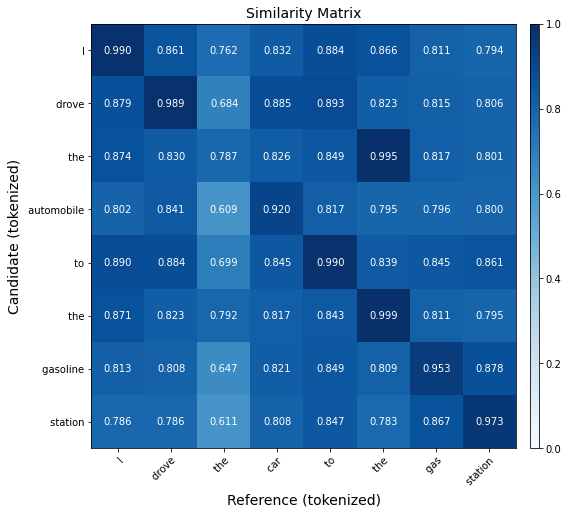

In [ ]:
# Import BERTScore's plot function
from bert_score import plot_example

# Plot the similarity matrix
hyp = hypothesis[0]
ref = reference[0]
plot_example(hyp, ref, lang="en")

In this similarity matrix, you can see, for example, the BERTScore assigns a very high similarity value of 0.92 to the two words *automobile* and *car*, and an even higher value of 0.95 to the two words *gasoline* and *gas*. This again illustrates that embedding-based metrics measure *semantic* similarity and not *formal* similarity (while string-based metrics measure formal similarity and not semantic similarity).

### 3.2 Your own Example. 

You can type in your own English hypothesis and reference sentences to calculate a BERTScore (same as above).
BERTScore covers a large range of languages listed [here](https://github.com/google-research/bert/blob/master/multilingual.md#list-of-languages). Feel free to change hypothesis and reference according to your requirements. Note: For languages other than English, the command *lang="en"* has to be changed to the relevant input language.

In [ ]:
# Enter machine-translated sentence (hypothesis) and the human reference translation (reference)
own_BERT_hypothesis = input("\nEnter the machine-translated sentence here: ")
own_BERT_reference = input("\nEnter the human-translated sentence here: ")

In [ ]:
# Calculate BERTScore
P, R, F1 = score([own_BERT_hypothesis], [own_BERT_reference], lang="en", rescale_with_baseline=True, verbose=True)
# Remember to change the language lang="en" if you input a non-english sentence (let's say for German: lang="de")

# Print Rbert, Pbert and Fbert
print(f"\nBERTScore-Recall: {R}\n")
print(f"BERTScore-Precision: {P}\n")
print(f"BERTScore-F-Measure: {F1}")

Run the code below to plot a similarity matrix four your own hypothesis-reference pair. Note: For languages other than English, the command *lang="en"* (in the last line in the code below) has to be changed to the relevant input language.

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


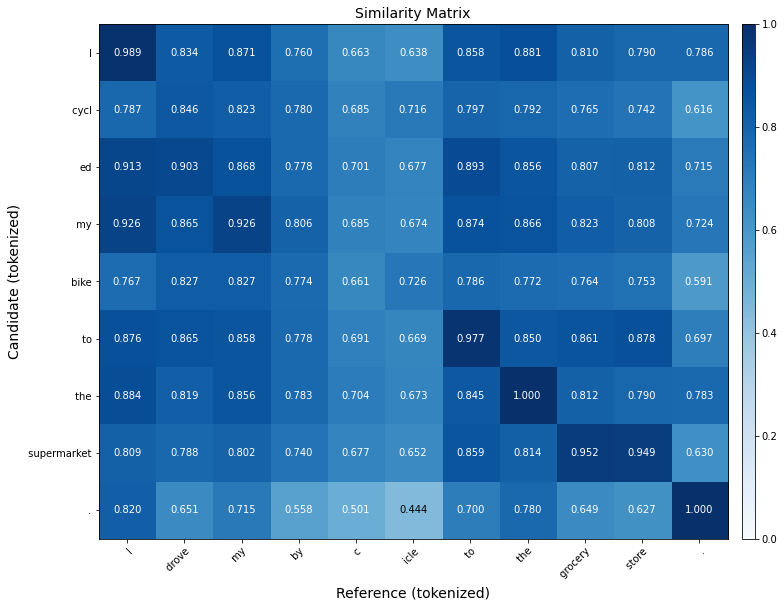

In [ ]:
# Import BERTScore's plot function
from bert_score import plot_example

# Plot the similarity matrix
own_hyp = own_BERT_hypothesis
own_ref = own_BERT_reference
plot_example(own_hyp, own_ref, lang="en")   # Change language code here if necessary

## 4 COMET: semantic similarity + human quality judgements

COMET is an embedding-based metric relying on semantic similarity in vector space and trained additionally on human quality judgements. **COMET** is an acronym for **C**rosslingual **O**ptimized **M**etric for **E**valuation of **T**ranslation. It was originally proposed  in [Rei et al. (2020): COMET: A Neural Framework for MT Evaluation](https://www.aclweb.org/anthology/2020.emnlp-main.213/). In contrast to traditional MT quality metrics based on string matching (such as BLEU or TER) and in contrast to the embedding-based metric BERTScore, COMET uses not only the machine-translated hypothesis and the human-translated reference but also the original source sentence. These three sentences are fed into a pre-trained cross-lingual encoder which embeds them in a multilingual vector space. The cross-lingual encoder is based on the multilingual language model *XLM-RoBERTa (XLM-R)*, which was first proposed in [Conneau et al. 2020: Unsupervised Cross-Lingual Representation Learning at Scale](https://arxiv.org/abs/1911.02116). In this multilingual vector space, not only embeddings of words from the same language but also embeddings of words from different languages cluster together based on their shared semantic meaning. Drawing on this multilingual vector space, COMET can establish both the semantic similarity between hypothesis and reference as well as the semantic similarity between source and hypothesis/reference. BERTScore, in contrast, only works with embeddings in a monolingual vector space (you can choose different monolingual vector spaces in BERTScore, but never a multilingual vector space).
There are three basic COMET models available, as shown in the figure below:

<img src="https://raw.githubusercontent.com/Unbabel/COMET/docs-config/docs/source/_static/img/architectures.jpg">

The model on the left side is called *Estimator Model* or *Regression Metric*. The model considers the hypothesis (*h*), the reference translation (*r*) and the source sentence (*s*). For these three sentences, the model obtains contextualised word embeddings from the multilingual vector space of XLM-RoBERTa (*XLM-R*), pools these individual word vectors into three sentence vectors and then concatenates these three sentence vectors into a single vector. Based on this concatenated vector (containing source, hypothesis and reference), a *Feed-Forward Regressor* then calculates the final quality score. The COMET Estimator model is trained on human error annotations based on the [Multidimensional Quality Metrics (MQM) Framework](https://themqm.org) and a human ranking of MT outputs on a 100-point ranking scale (Direct Assessment).

The model in the middle is called *Translation Ranking Model* or *Ranking Metric*. Again, this model considers source (*s*) and reference (*r*), but in contrast to the first model, it considers *two* hypotheses, one that was ranked better in a human Direct Assessment (*p*, positive) and one that was considered worse in this assessment (*n*, negative). As in the first model, we obtain contextualised word embeddings from XLM-R, and pool them into sentence vectors. Using a technique called *Triplet Margin Loss* (no need to go into any more detail here), the multilingual vector space of the sentence vectors is then adjusted in such a way that the distance between source vector/reference vector and the vector of the *worse* of the two hypotheses is *increased* (in vector space logic, this equals a *lower* semantic similarity between these vectors) and the distance between the source vector/reference vector and the vector of the *better* of the two hypotheses is *decreased* (in vector space logic, this equals a *higher* semantic similarity between these vectors). When computing an actual quality score, the model only considers source, reference and the hypothesis to be scored. The quality score is calculated as the harmonic mean of the Eucledian distance between hypothesis and source and the Eucledian distance between hypothesis and reference (and now we take a deep breath).

The model on the right side is called *Reference-free COMET* or *Referenceless Metric*. It resembles the Estimator Model on the left side but differs from this model and from the Translation Ranking Model in that it considers only a source and a hypothesis and no human reference translation (hence *reference-free* or *referenceless*). What this model performs is not an MT quality *evaluation* but an MT quality *estimation*, since it does not take into account a human reference translation as gold standard, which would tell the model for certain whether it is dealing with a good or a bad MT hypothesis. The Reference-free Model is also trained on human DA rankings and MQM error annotations. 
An overview of these models together with information on how to load them can be found in the official [COMET GitHub repository](https://github.com/Unbabel/COMET).

### 4.0 Installing COMET
First, we need to install the packages required to compute COMET scores. The various COMET models are implemented as part of the unbabel-comet package available in the official [COMET GitHub repository](https://github.com/Unbabel/COMET). Since embedding-based metrics rely on large embedding models, installing COMET and loading the model will usually take some time (same as with BERTScore).

Note: Running this cell might result in the notebook requesting you to restart the runtime: "You must restart the runtime in order to use the newly installed version". You can restart the runtime in the menu under "runtime" --> "restart runtime". Then, you must run the cell in chapter 0 and the cell below again before moving on to section 4.1.


In [ ]:
# Install the most recent unbabel-comet package
!pip install unbabel-comet==1.1.3

# In case this is outdated, check out the newest version or simply uncomment and install the line below
#!pip install unbabel-comet

Below, we will illustrate two different models: a lightweight version of the original COMET metric and a reference-free quality estimation version that calculates a quality estimation score based solely on a hypothesis and a source sentence.

### 4.1 Lightweight COMETinho Version of the Estimator/Regression Model

One of the most recent and efficient models is COMETinho, [Rei et al. (2022): Searching for COMETinho: The Little Metric That Could](https://aclanthology.org/2022.eamt-1.9/). We also COMETinho in this notebook, as it is a streamlined 'lightweight' version of the original COMET, which offers basically the same performance as the bigger COMET models, but at a much faster speed (meaning that it loads much faster).
Below, we load COMETinho version of the COMET Estimator/Regression Model discussed above (`eamt22-cometinho-da`).

In [ ]:
# Loading the COMETinho 'eamt22-cometinho-da' model
from comet import download_model, load_from_checkpoint
model_path_inho = download_model("eamt22-cometinho-da")
model_inho = load_from_checkpoint(model_path_inho)

### 4.1.1 Short Example Using Single Sentences

The cell below calculates a COMETinho Estimator score for one hypothesis. Note that we do not only have to specify the human reference translation, but also the source sentence (we deviate here from our previous example sentences, as COMET is a different beast than the other MT quality metrics we covered in this notebook).

In [ ]:
# Defining source, hypothesis and reference sentences
data = [{ "src": "If you do not agree to these Conditions do not use this website.",
          "mt": "Wenn Sie mit diesen Bedingungen nicht einverstanden sind, benutzen Sie diese Website nicht.",
          "ref": "Wenn Sie mit diesen Bedingungen nicht einverstanden sind, sehen Sie von einer Nutzung dieser Website ab."      }]

# Calculate COMET scores
seg_scores, sys_score = model_inho.predict(data, batch_size=8, gpus=0) # This can be changed to 'gpus=1' if GPU is available
print("\nSegment scores:", seg_scores) # for multiple sentences
print("COMETinho score:", sys_score)

As you can see, we obtain a COMETinho score of around 0.68 for our hypothesis/reference/source combination. Above the COMETinho value, you can see a segment score, which indicates the COMETinho score per sentence (= per segment). Since we only compute a score for one hypothesis in this example, the sentence score is identical to the overall COMETinho score. If you calculate a score for multiple sentences (as we do below), you would have multiple segment scores, and one overall COMETinho score. COMET(inho) scores are more difficult to interpret than the previous scores we covered in this notebook, since individual scores will have to be interpreted within the overall range of scores that were obtained using the respective COMET(inho) model in larger MT quality evaluation campaigns. So, scores such as 0.68 do not tell us anything by themselves but have to be interpreted relative to a COMET model’s score range. More information on this can be found in the [official COMET Documentation](https://unbabel.github.io/COMET/html/faqs.html#is-there-a-theoretical-range-of-values-for-the-comet-regressor) (the documentation does not provide any specific information on the COMETinho model we used in our example, so we don’t quite know whether 0.68 is a good or a bad score).

### 4.1.2 Another Example Using Multiple Sentences
As mentioned above, you could also calculate an average COMETinho score for multiple sentences, with a different value for each segment (sentence). This is illustrated below.

In [ ]:
# Defining source, hypothesis and reference sentences
data = [{ "src": "If you do not agree to these Conditions do not use this website.",
          "mt": "Wenn Sie mit diesen Bedingungen nicht einverstanden sind, benutzen Sie diese Website nicht.",
          "ref": "Wenn Sie mit diesen Bedingungen nicht einverstanden sind, sehen Sie von einer Nutzung dieser Website ab."      },
        {"src": "Please read these Conditions; they are important.",
         "mt": "Bitte lesen Sie diese Bedingungen; sie sind wichtig.",
         "ref": "Bitte lesen Sie diese Bedingungen durch; sie sind wichtig."        } ]

# Calculate COMET scores
seg_scores, sys_score = model_inho.predict(data, batch_size=8, gpus=0) # This can be changed to 'gpus=1' if GPU is available
print("\nSegment scores:", seg_scores) # for multiple sentences
print("COMETinho score:", sys_score)

Here, we score two MT hypotheses and obtain two segment/sentence scores of 0.68 (for the first segment/sentence, as in the example above) and of 0.99 (for the second segment/sentence). The final COMETinho score of 0.83 is simply the average of the two segment/sentence scores. Again, we do not quite know what to make of the final score, but we can see that COMETinho scores the second segment (where MT hypothesis and reference are identical) much higher than the first segment. You could also use this COMETinho model to score segments where source and reference are identical and where only the MT hypothesis differs. This way, you could check which hypothesis COMETinho considers to be the better one.

## 4.2 Reference-free COMET Model for MT Quality Estimation

Below, we illustrate the Reference-free COMET Model for MT quality estimation. As mentioned above, MT quality estimation differs from MT quality evaluation in that it does not use a human reference translation (gold standard) which would tell our metric upfront how an ideal MT hypothesis should look like. In the cell below, we load the Reference-Free COMET Model discussed in section 4 below. You’ll notice that loading this full COMET model takes considerably longer than loading the lightweight COMETinho model above.

In [ ]:
#!pip install --upgrade torch==1.9.0
#!pip install --upgrade torchvision==0.10.0

In [ ]:
from comet import download_model, load_from_checkpoint
model_path = download_model("wmt21-comet-qe-mqm")
model = load_from_checkpoint(model_path)

In practical translation scenarios, MT quality estimation could be used, for example, to decide which MT output from multiple MT engines to provide to translators in their CAT tool. Let’s assume that you have to translate the source sentence in the cell below in Trados Studio, Phrase, memoQ or any other CAT tool of your choice. Let us further assume that there are two MT engines running in the background, the output of which could be provided in the editor of the CAT tool. In order to avoid cognitive overload, we only want the CAT tool to display the better of the two outputs so that we can focus our cognitive resources on this output. Also in the background, we would first calculate a quality estimation score for the output of engine A. Run the cell below to do so.

In [ ]:
data = [{
          "src": "If you do not agree to these Conditions do not use this website.",
          "mt": "Wenn Sie mit diesen Bedingungen nicht einverstanden sind, benutzen Sie diese Website nicht."
}]
model.predict(data, gpus=0)

Again, we obtain a segment score and a final score, which are identical because we only score one segment. The score of 0.15 is again difficult to interpret by itself, but here we want to compare it to the quality estimation score for the output of engine B. We calculate this score by running the cell below.

In [ ]:
data = [{
          "src": "If you do not agree to these Conditions do not use this website.",
          "mt": "Ich bin froh, wenn dieses Notebook endlich zu Ende ist."
}]
model.predict(data, gpus=0)

As you can see, the quality estimation score for engine B is 0.11. Since the MT output used in this example does not have anything in common with the source sentence, we actually may have expected an even lower score. Be that as it may, if we have two MT engines at our disposal and calculate quality estimation scores in the background as done here, the output of engine A would be provided in our CAT tool for post-editing and the output of engine B would be discarded.

Congratulations! You have now successfully calculated various automatic MT quality evaluation metrics and should now have a sound understanding of how the individual scores work, how they are interpreted and what their individual advantages and shortcomings are. You are now well prepared to evaluate the quality of MT systems and of machine-translated texts, which is becoming a more and more relevant task in the professional translation industry. If you would like to evaluate the quality of an entire document, you can use our [companion notebook on quality evaluation at document level](https://colab.research.google.com/drive/19a896dbRBVtJmqA6JIFBU7bUiASfAo6V?usp=sharing) to calculate an average metric for an entire document. You could also use your knowledge to perform an automatic quality evaluation of your own NMT model, which you can train in our [NMT Training notebook](https://colab.research.google.com/drive/1f3V7CshfVvrA5S6XtLAvl-beqBPN3qar?usp=sharing).